In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv('/Users/cynding/Desktop/Brandeis 2021 Fall/BUS 256A - Marketing Analytics/final project/marriott_hotel_reviews.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3179 entries, 0 to 3178
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Customer         3176 non-null   object 
 1   Member_Type      2277 non-null   object 
 2   Traveler_Type    3164 non-null   object 
 3   Date             3179 non-null   object 
 4   Review           3156 non-null   object 
 5   Total_Score      3179 non-null   float64
 6   Cleanliness      3158 non-null   float64
 7   Dining           2849 non-null   float64
 8   Location         3155 non-null   float64
 9   Service          3155 non-null   float64
 10  Amenities        3118 non-null   float64
 11  Value_for_Money  3152 non-null   float64
 12  Hotel            3179 non-null   object 
dtypes: float64(7), object(6)
memory usage: 323.0+ KB


### Clean Text Data

In [2]:
df['Review']=df['Review'].astype(str)

In [3]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

'''
Part-Of-Speech (POS) tagging: assign a tag to every word to define 
if it corresponds to a noun, a verb etc. using the WordNet lexical database
'''

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [4]:
def clean_text(text):
    # lower text
    text = text.lower()
    #
    text = text.replace("n't"," not")
    text = text.replace("i'm","i am")
    text = text.replace("i'd","i would")
    text = text.replace("i've","i have")
    text = text.replace("could've","could have")
    text = text.replace("we're","we are")
    text = text.replace("'ll"," will")
    text = text.replace("that's","that is")
    
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text: transform every word into their root form 
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
df['Review'] = df['Review'].apply(lambda x: clean_text(x))

### Feature Engineering

In [5]:
# add sentiment anaylsis columns
#from nltk.sentiment.vader import SentimentIntensityAnalyzer

#sid = SentimentIntensityAnalyzer()
#df['sentiments'] = df['Review'].apply(lambda x: sid.polarity_scores(x))
#df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
tfidf = TfidfVectorizer(min_df = 5)
tfidf_result = tfidf.fit_transform(df['Review'].astype('U')).toarray()
tfidf_df = pd.DataFrame(tfidf_result,columns=tfidf.get_feature_names_out())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = df.index
df = pd.concat([df, tfidf_df], axis=1)

### Modelling

#### The classifiers I have used
- Random Forest Classifier
- Naive-Bayes Classifier
- KNN Classifier

In [8]:
from sklearn.model_selection import train_test_split

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

In [9]:
label = 'Total_Score'
features = [c for c in tfidf_df.columns]

X_train, X_test, y_train, y_test = train_test_split(df[features], df[label], test_size = 0.20, random_state = 42)

#### 1. Random Forest Classifier

In [10]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
# n_estimators is the number of trees you want to build before taking the maximum voting or averages of predictions
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rf_train_score = rf.score(X_train,y_train)
rf_test_score = rf.score(X_test,y_test)

#### 2. Naive Bayes Classifier

In [11]:
# train a naive bayes classifier
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

mnb_train_score = mnb.score(X_train,y_train)
mnb_test_score = mnb.score(X_test,y_test)

/Users/cynding/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


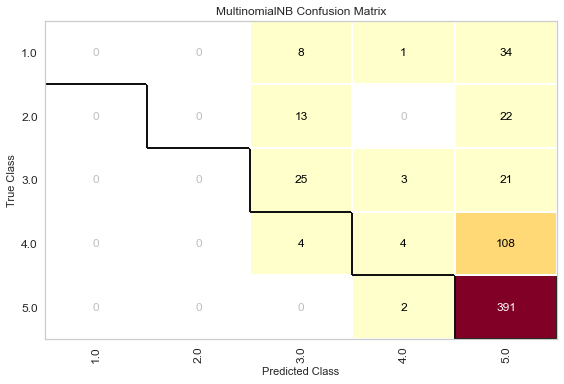

<AxesSubplot:title={'center':'MultinomialNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [13]:
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(mnb)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

In [14]:
pip install yellowbrick

You should consider upgrading via the '/Users/cynding/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


#### 3. KNN Classifier

In [15]:
# train a knn classifier

# find the number of neighbors with the best performance
n_neighbors_n = [10,25,50,100,200]
for i in n_neighbors_n:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    print('Number of neighbors',i)
    print('Test score:',knn.score(X_test,y_test))

Number of neighbors 10
Test score: 0.35062893081761004
Number of neighbors 25
Test score: 0.3742138364779874
Number of neighbors 50
Test score: 0.6572327044025157
Number of neighbors 100
Test score: 0.6226415094339622
Number of neighbors 200
Test score: 0.6179245283018868


The number of neighbors with the best performance is 100.

In [16]:
knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(X_train, y_train)

knn_train_score = knn.score(X_train,y_train)
knn_test_score = knn.score(X_test,y_test)

In [17]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names=['Model','Train Score','Test Score']
x.add_row(['Random Forest',"{:.2%}".format(rf_train_score),"{:.2%}".format(rf_test_score)])
x.add_row(['Naive-Bayes',"{:.2%}".format(mnb_train_score),"{:.2%}".format(mnb_test_score)])
x.add_row(['KNN',"{:.2%}".format(knn_train_score),"{:.2%}".format(knn_test_score)])
print(x)

+---------------+-------------+------------+
|     Model     | Train Score | Test Score |
+---------------+-------------+------------+
| Random Forest |    85.73%   |   65.25%   |
|  Naive-Bayes  |    69.25%   |   66.04%   |
|      KNN      |    64.77%   |   62.26%   |
+---------------+-------------+------------+


Among these three models, I chose Naive-Bayes as it gets the highest test accuracy with minor overfitting problem.

In [18]:
# Estimate the confusion matrix
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_test, y_pred)
print(cmat)

from yellowbrick.classifier import ConfusionMatrix

[[  0   2  12   2  27]
 [  5   4  11   2  13]
 [  3   3  27   0  16]
 [  2   0   7   7 100]
 [  1   3   4   8 377]]
